In [2]:
import numpy as np
import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.risk as risk
import mlgrad.avragg as avragg
# import mlgrad.gd as gd
import mlgrad.func2 as func2
import mlgrad.weights as weights
from mlgrad.utils import exclude_outliers

import mlgrad.regr as regr

from mlgrad import averager_it, averager_fg, fg, erm_fg, sg, erm_sg, irgd, erm_irgd, erisk, mrisk

#import sklearn.linear_model as sklm

import pandas as pd
import matplotlib.pyplot as plt

import sys
print(sys.version)

3.11.1 (main, Dec 31 2022, 10:23:59) [GCC 12.2.0]


In [3]:
df = pd.read_csv("data/tonedata.csv", sep=' ')

In [4]:
len(df)

150

In [5]:
df

,stretchratio,tuned
0,1.35,1.461
1,1.40,1.407
2,1.45,1.452
3,1.50,1.300
4,1.55,1.351
...,...,...
145,2.75,2.066
146,2.80,2.426
147,2.85,2.117
148,2.90,2.097


In [6]:
X = df["stretchratio"].values
Y = df["tuned"].values

X -= np.median(X)
Y -= np.median(Y)

# x_min, x_max = X.min(), X.max()
# X = (X - x_min) / (x_max - x_min)
# y_min, y_max = Y.min(), Y.max()
# Y = (Y - y_min) / (y_max - y_min)

Xs = X.reshape((-1,1))

X0 = np.linspace(X.min(), X.max(), 20)

In [7]:
from sklearn.preprocessing import scale

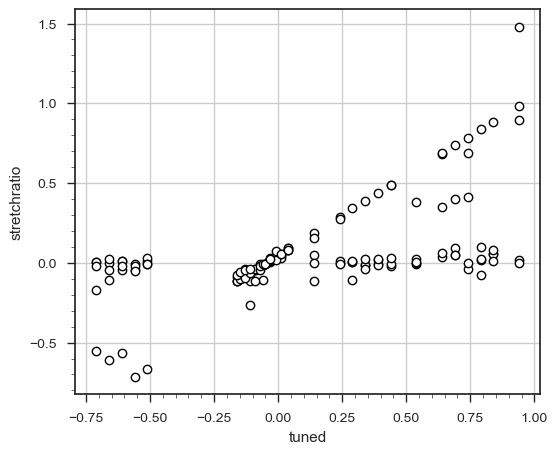

In [8]:
plt.figure(figsize=(6.0, 5.0))
plt.scatter(X, Y, s=36, c='w', edgecolors='k', linewidths=1.)
# plt.title('starCYGs')
plt.minorticks_on()
plt.grid(1)
plt.ylabel('stretchratio')
plt.xlabel('tuned')
# plt.xlim(-0.9, 0.6)
# plt.ylim(-2.5, 2.0)
plt.show()

In [9]:
loss_func_sq = loss.ErrorLoss(func.Square())
# loss_func_rsq = loss.RelativeErrorLoss(func.Square())
loss_func_abs = loss.ErrorLoss(func.Absolute())

In [10]:
sqr_norm = func2.SquareNorm()

In [11]:
def curve_fit_and_errors(alg):
    err = np.abs(Y - alg.risk.model.evaluate_all(Xs))
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.title('Fit curve')
    plt.plot(alg.lvals)
    plt.xlabel('step')
    plt.ylabel('mean of errors')
    plt.minorticks_on()
    plt.subplot(1,2,2)
    plt.title('Errors')
    plt.plot(sorted(err), marker='s', markersize='6')
    plt.minorticks_on()
    plt.xlabel('error rank')
    plt.ylabel('error value')
    plt.show()
    return err

In [12]:
mod_ls = model.LinearModel(1)
mod_ls.init_param()

K=1499 param=[0.05159054 0.31258317]


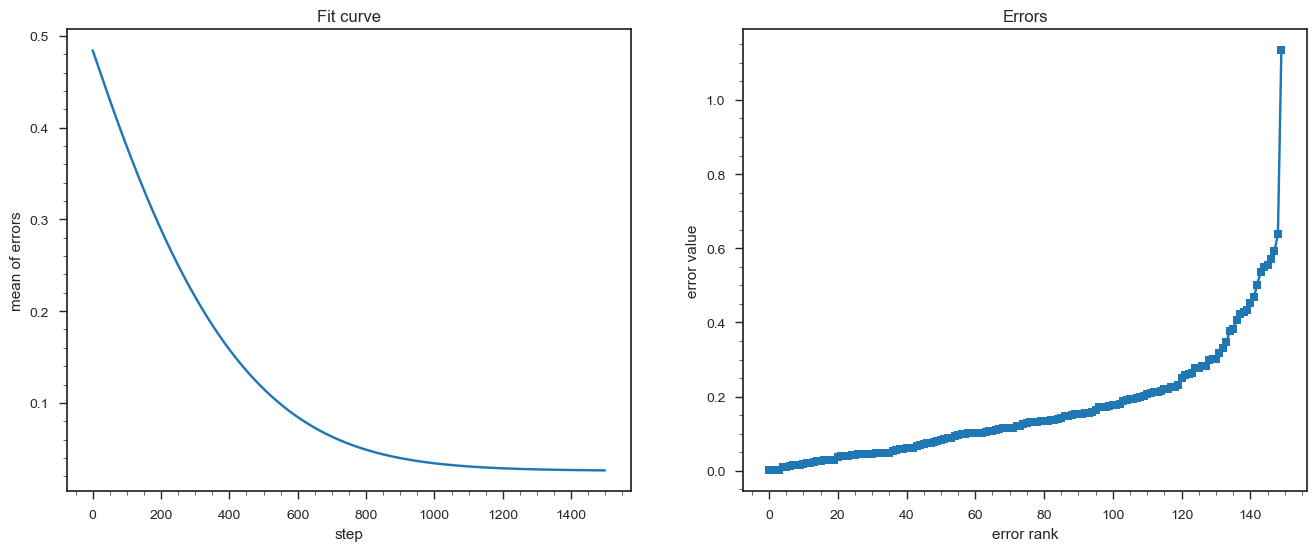

In [13]:
alg_ls = regr.regression(Xs, Y, mod_ls, n_iter=1500, verbose=1)
err_ls = curve_fit_and_errors(alg_ls)

In [15]:
mod_m_irls = model.LinearModel(1)
mod_m_irls.init_param()

0.0010547693411128373
K=4 param=[0.05012485 0.98218305]


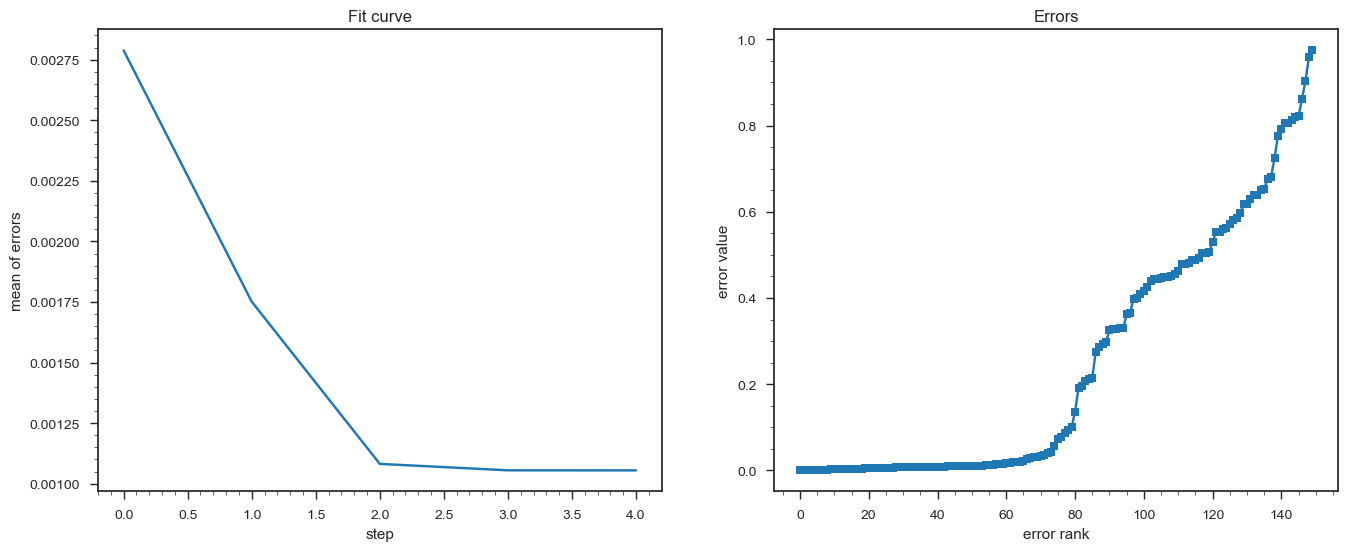

In [16]:
avg_m_irls = regr.averaging_function('M', rhofunc=func.Quantile_Sqrt(0.4, 0.001))
alg_m_irls = regr.m_regression_irls(Xs, Y, mod_m_irls, agg_func=avg_m_irls, h=0.001, n_iter2=70, verbose=1)
err_m_irls = curve_fit_and_errors(alg_m_irls)

In [18]:
mod_wm_irls = model.LinearModel(1)
mod_wm_irls.init_param()

0.0018035793742335307
K=4 param=[0.01661002 0.58114996]


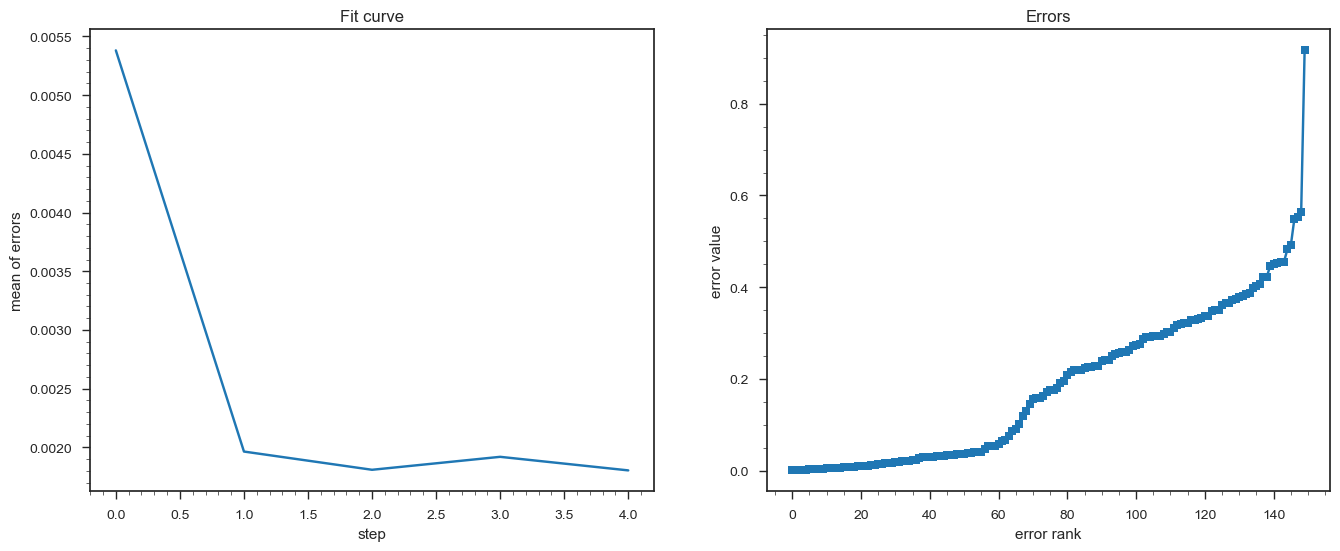

In [19]:
avg_wm_irls = regr.averaging_function('WM', rhofunc=func.Quantile_Sqrt(0.4, 0.001))
alg_wm_irls = regr.m_regression_irls(Xs, Y, mod_wm_irls, agg_func=avg_wm_irls, h=0.001, n_iter2=70, verbose=1)
err_wm_irls = curve_fit_and_errors(alg_wm_irls)

In [21]:
mod_swm_irls = model.LinearModel(1)
mod_swm_irls.init_param()

0.01012230319126554
K=6 param=[0.01204895 0.45347913]


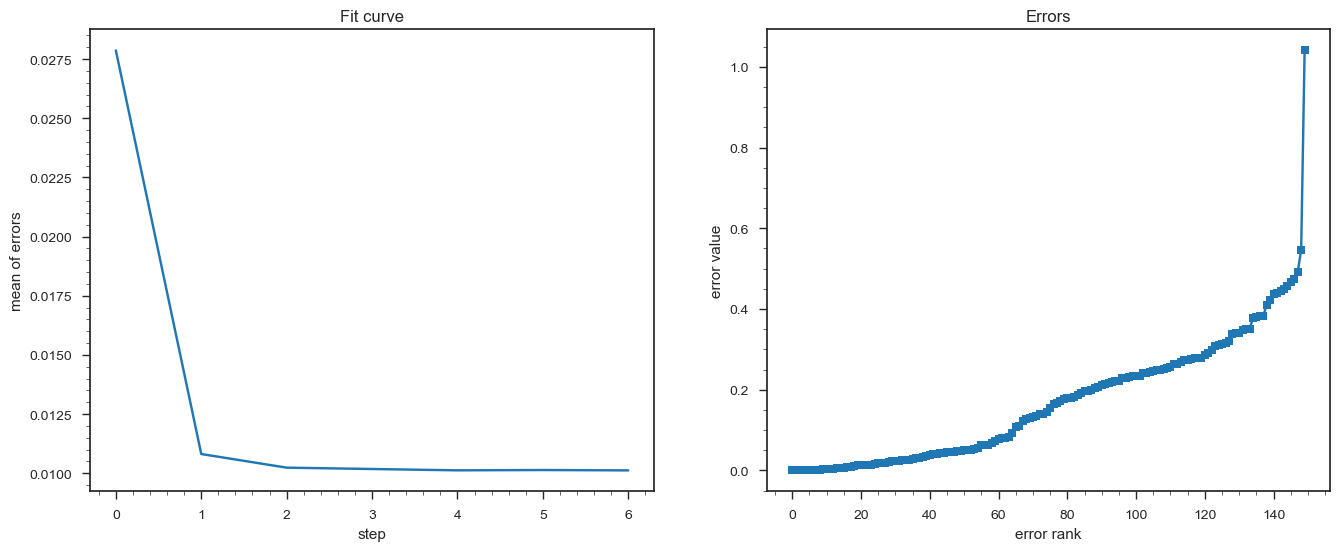

In [22]:
avg_swm_irls = regr.averaging_function('SWM', rhofunc=func.Quantile_Sqrt(0.4, 0.001))
alg_swm_irls = regr.m_regression_irls(Xs, Y, mod_swm_irls, agg_func=avg_swm_irls, h=0.001, tol=1.0e-8, verbose=1)
err_swm_irls = curve_fit_and_errors(alg_swm_irls)

In [23]:
# Err = np.abs(Y - mod2.evaluate_all(Xs))

# X1, X1_ = array_exclude_outliers(X, Err, 7) 
# Y1, Y1_ = array_exclude_outliers(Y, Err, 7) 
# X1s = X1.reshape(-1,1)

In [24]:
mod_r_irls = model.LinearModel(1)
mod_r_irls.init_param()

0.13594699491770398
K=18 param=[-0.00579798  0.07719818]


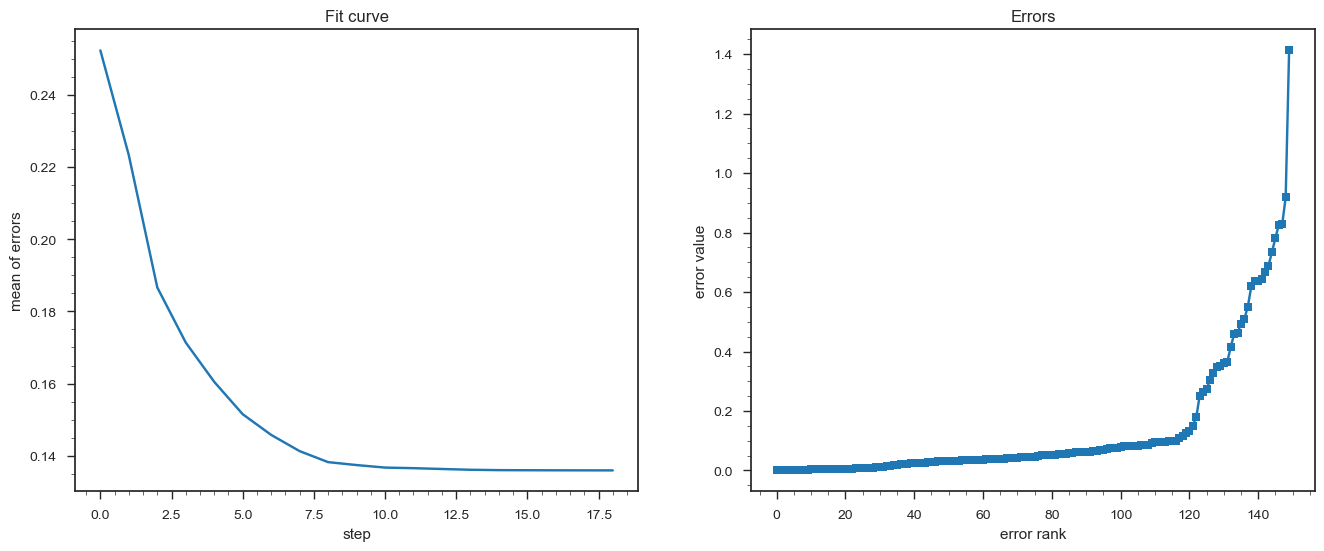

In [26]:
alg_r_irls = regr.r_regression_irls(Xs, Y, mod_r_irls, rho_func=func.Sqrt(0.001), verbose=1)
err_r_irls = curve_fit_and_errors(alg_r_irls)

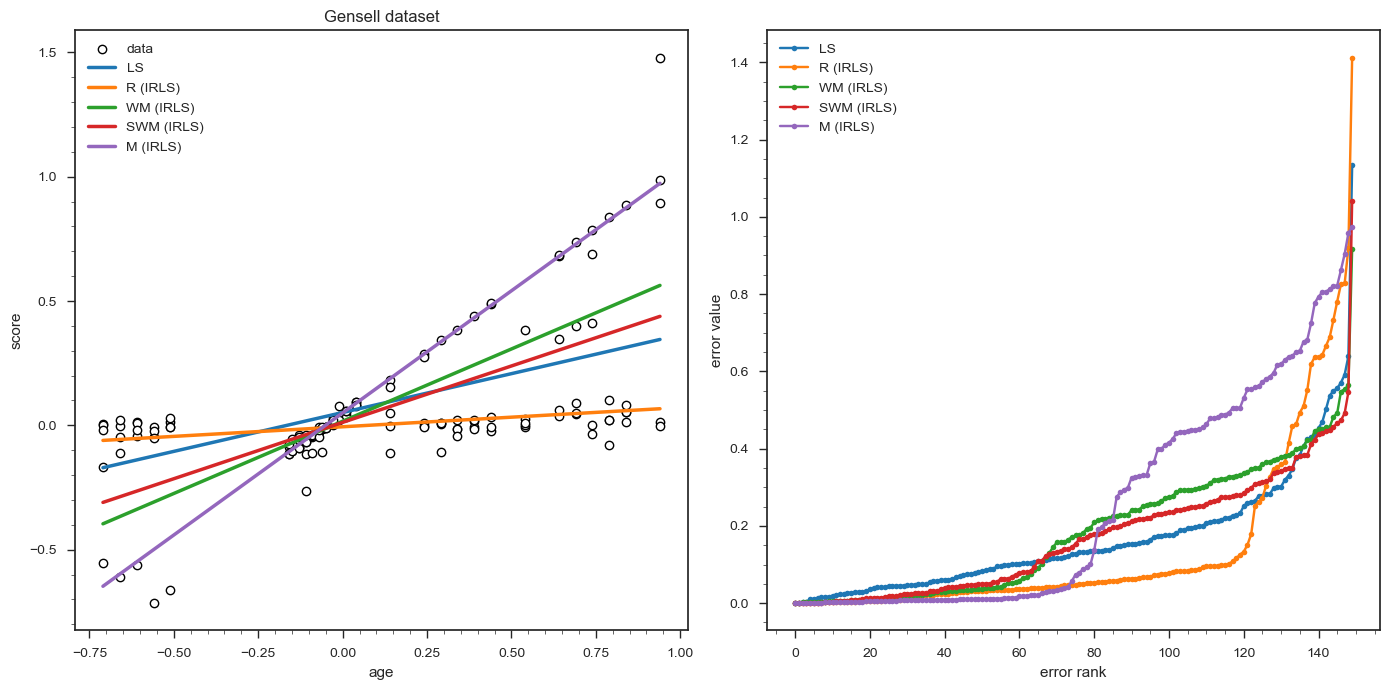

In [27]:
plt.figure(figsize=(14.0, 7.0))
plt.subplot(1,2,1)
plt.title('Gensell dataset')
plt.scatter(X, Y, s=36, c='w', edgecolors='k', linewidths=1., label='data')
plt.plot(X0, mod_ls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'LS')
plt.plot(X0, mod_r_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'R (IRLS)')
plt.plot(X0, mod_wm_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'WM (IRLS)')
# plt.plot(X0, mod_wm_ls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'WM (LS)')
plt.plot(X0, mod_swm_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'SWM (IRLS)')
plt.plot(X0, mod_m_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'M (IRLS)')
plt.minorticks_on()
# plt.grid(1)
plt.xlabel('age')
plt.ylabel('score')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(sorted(np.abs(Y - mod_ls.evaluate_all(Xs))), marker='o', markersize=4, label=r'LS')
plt.plot(sorted(np.abs(Y - mod_r_irls.evaluate_all(Xs))), marker='o', markersize=4, label=r'R (IRLS)')
plt.plot(sorted(np.abs(Y - mod_wm_irls.evaluate_all(Xs))), marker='o', markersize=4, label=r'WM (IRLS)')
# plt.plot(sorted(np.abs(Y - mod_wm_ls.evaluate_all(Xs))), marker='o', markersize=4, label=r'WM (LS)')
plt.plot(sorted(np.abs(Y - mod_swm_irls.evaluate_all(Xs))), marker='o', markersize=4, label=r'SWM (IRLS)')
plt.plot(sorted(np.abs(Y - mod_m_irls.evaluate_all(Xs))), marker='o', markersize=4
         , label=r'M (IRLS)')
plt.minorticks_on()
# plt.grid(1)
plt.ylabel('error value')
plt.xlabel('error rank')
# plt.ylim(-0.1, 4.5)
# plt.xlim(-1, 48)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [27]:
41/47

0.8723404255319149

Типичный пример, иллюстрирующий возникновение двух линейных зависимостей связан с восприятием тонов в музыке и возникновенем овертонов